In [1]:
import os
import pandas as pd
import jax.numpy as jnp
import numpy as np

data_path = os.path.join("./datasets/")

In [2]:
# @title prepare_training_data
def prepare_training_data(data, n_obs):
  df_train = data.head(n_obs)
  df_test = data.tail(40)

  x_train, y_train, f_train = df_train, df_train.pop("y"), df_train.pop("f")
  x_test, y_test, f_test = df_test, df_test.pop("y"), df_test.pop("f")

  x_train = x_train.to_numpy()
  x_test = x_test.to_numpy()

  y_train = y_train.to_numpy().reshape(-1, 1).ravel()
  y_test = y_test.to_numpy().reshape(-1, 1).ravel()  
  return x_train, y_train, x_test, y_test

In [3]:
dataset_name = 'adult' # @param ['cat', 'cont', 'adult', 'heart', 'mi'] 
outcome_type = 'matern32' # @param ['linear', 'rbf', 'matern32', 'complex']
n_obs = 200 # @param [100, 200, 500, 1000]
dim_in = 25 # @param [25, 50, 100, 200]
rep = 1 # @param 

data_file = f"{outcome_type}_n{n_obs}_d{dim_in}_i{rep}.csv"
data_file_path = os.path.join(data_path, dataset_name, data_file)
print(f"Data '{data_file}'", end='\t', flush=True)  

data = pd.read_csv(data_file_path, index_col=0)  
x_train, y_train, x_test, y_test = prepare_training_data(data, n_obs)

Data 'matern32_n200_d25_i1.csv'	

In [4]:
from vie import get_fdt_model
fdt_out = get_fdt_model(x_train, y_train, c=0.1, sig2=0.01, n_tree=20, 
                            compute_psi=True, batch_size=1, n_samp=10, seed=0)
# number of observations = 200
# number of samples for beta, given each x, = 10
# number of poster samples = 100 * 10 = 1000
# number of trees = 20
# number of features = 50

Shapes: psi_est_all: (2000, 1, 20, 25), grad_train: (20, 25), psi_est: (25,)


In [5]:
psi_est_all = fdt_out[0]
psi_est_all.shape

(2000, 1, 20, 25)

In [6]:
psi_est_all = psi_est_all.reshape(psi_est_all.shape[0], psi_est_all.shape[2], psi_est_all.shape[3])
psi_est_all.shape

(2000, 20, 25)

In [7]:
from jax import vmap
from jax.numpy import outer
# Take outer product for each sample and each tree
vouter = vmap(vmap(outer))
H_s = vouter(psi_est_all, psi_est_all)
H_s.shape

(2000, 20, 25, 25)

In [8]:
# Average over all samples
H_hat = jnp.mean(H_s, axis = 0)
H_hat.shape

(20, 25, 25)

In [9]:
# Average over all trees
H_hat = jnp.mean(H_hat, axis = 0)
H_hat.shape

(25, 25)

In [10]:
import matplotlib.pyplot as plt

def plot_spectrum(y, y_diag, title):
    x = np.linspace(0, dim_in-1, dim_in)

    fig, ax = plt.subplots()

    ax.plot(x, y, linewidth=2.0, label = "eig")
    ax.plot(x, y_diag, linewidth=2.0, label = "diagonal")

    plt.legend()
    plt.title(title)
    plt.show()

/Users/yangxinyuxie/miniforge3/envs/venv/lib/python3.10/site-packages/jax/_src/array.py:351: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


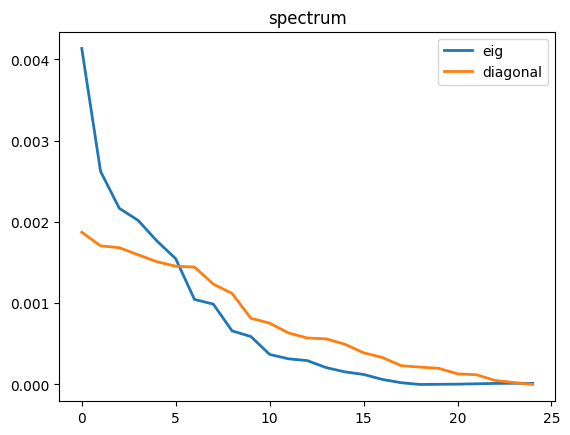

In [11]:
y = jnp.linalg.eig(H_hat)[0]
y_diag = jnp.diagonal(H_hat)
y_diag = jnp.sort(y_diag)[::-1]
plot_spectrum(y, y_diag, 'spectrum')

In [12]:
'''
log_y = jnp.log(y)
log_y_diag = jnp.log(y_diag)
plot_spectrum(log_y, log_y_diag, 'log spectrum')
'''

"\nlog_y = jnp.log(y)\nlog_y_diag = jnp.log(y_diag)\nplot_spectrum(log_y, log_y_diag, 'log spectrum')\n"

In [13]:
H_hat = jnp.mean(H_s, axis = 0)
H_hat.shape

(20, 25, 25)

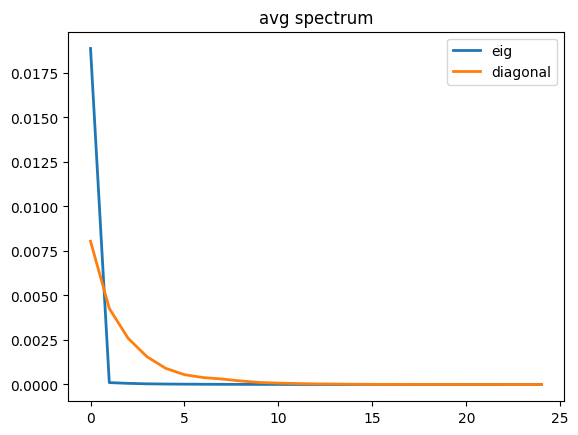

In [14]:
veig = vmap(jnp.linalg.eig, out_axes=0)
eigs = veig(H_hat)[0]
eigs
vdiag = vmap(jnp.diagonal)
diags = vdiag(H_hat)
y = jnp.mean(eigs, axis = 0)
diags = vmap(jnp.sort)(diags)
y_diag = jnp.mean(diags, axis = 0)[::-1]
plot_spectrum(y, y_diag, 'avg spectrum')

In [15]:
'''
log_y = jnp.log(y)
log_y_diag = jnp.log(y_diag)
plot_spectrum(log_y, log_y_diag, 'log spectrum')
'''

"\nlog_y = jnp.log(y)\nlog_y_diag = jnp.log(y_diag)\nplot_spectrum(log_y, log_y_diag, 'log spectrum')\n"

In [16]:
'''
for H in H_hat:
    y = jnp.linalg.eig(H)[0]
    y_diag = jnp.diagonal(H)
    y_diag = jnp.sort(y_diag)[::-1]
    log_y = jnp.log(y)
    log_y_diag = jnp.log(y_diag)
    plot_spectrum(log_y, log_y_diag, 'log spectrum')
'''

"\nfor H in H_hat:\n    y = jnp.linalg.eig(H)[0]\n    y_diag = jnp.diagonal(H)\n    y_diag = jnp.sort(y_diag)[::-1]\n    log_y = jnp.log(y)\n    log_y_diag = jnp.log(y_diag)\n    plot_spectrum(log_y, log_y_diag, 'log spectrum')\n"